<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    npr Mini-Challenge 1: <br>TFIDF-HGBC
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Jan Zwicky im HS 2023.
</p>

## Modellerklärung

Das Modell zur Klassifikation von Disaster Tweets besteht aus zwei Hauptkomponenten: einem Vectorizer und einem Classifier.

Der Vectorizer, in diesem Fall TFIDF (Term Frequency-Inverse Document Frequency), wandelt die Tweets in numerische Vektoren<br>
um. TFIDF berechnet für jedes Wort in einem Tweet einen Wert, der angibt, wie wichtig das Wort für den Tweet ist. Dabei wird<br>
die Häufigkeit des Wortes im Tweet (Term Frequency) mit der Seltenheit des Wortes im gesamten Textkorpus (Inverse Document<br>
Frequency) multipliziert. Dank der multiplikation mit der Inverse Document Frequency werden Wörter, die in vielen Tweets<br>
vorkommen, weniger stark gewichtet als Wörter, die nur in wenigen Tweets vorkommen. Die Vektorisierung ermöglicht es, <br>
die Tweets in einem numerischen Raum darzustellen, in dem ähnliche Tweets nahe beieinander liegen, wenn die gleichen Wörter <br>
verwendet wurden. Dies trifft bei Synonymen leider nicht zu, da diese als anderes Wort behandelt werden. <br>

Nachdem die Tweets mit dem Vectorizer in Vektoren umgewandelt wurden, werden sie dem Histogram Gradient Boosting Classifier<br>
zugeführt. Dieser Classifier ist eine Erweiterung des Gradient Boosting Classifiers und verwendet Histogramme, um die<br>
Effizienz des Trainings und der Vorhersage zu verbessern. Der Classifier lernt aus den TFIDF-Vektoren und<br>
erstellt ein Modell, das in der Lage ist, neue, nicht gekennzeichnete Tweets zu klassifizieren. Dabei wird der<br>
Disaster-Status (Ja/Nein) des Tweets vorhergesagt.

## Requirements, Imports und Einstellungen
Hier werden die benötigten Python-Pakete importiert und die Einstellungen für die Plots
vorgenommen. 

In [1]:
# All Imports
import sys
import html
import nltk
import torch
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Versions of the packages used
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {plt.matplotlib.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")
print(f"Seaborn Version: {sns.__version__}")
print(f"NLTK Version: {nltk.__version__}")
print()

# Warnings Settings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Numpy Settings
np.set_printoptions(precision=2, suppress=True)
np.random.seed(42)

# Matplotlib Settings
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["figure.dpi"] = 100

# Pandas Settings
pd.options.display.max_colwidth = None

# NLTK Settings
nltk.download("wordnet", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)

# End
print("Done!")


Python Version: 3.11.6 (main, Oct  2 2023, 13:45:54) [Clang 15.0.0 (clang-1500.0.40.1)]
PyTorch Version: 2.1.0
Numpy Version: 1.25.2
Pandas Version: 2.1.2
Matplotlib Version: 3.7.0
Sklearn Version: 1.3.1
Seaborn Version: 0.13.0
NLTK Version: 3.8.1

Done!


## Helper Functions/Classes

Hier werden Funktionen und Klassen definiert, die bei den Modellen verwendet werden.

In [2]:
# Metrics, shortcuts, constants, etc.
class Pipeline:
    """Pipeline for customizable text classification model."""

    def __init__(self, vectorizer, classifier, reducer=None) -> None:
        self.vectorizer = vectorizer
        self.classifier = classifier
        self.reducer = reducer

    def __repr__(self) -> str:
        return f"Pipeline(vectorizer={self.vectorizer}, classifier={self.classifier}, reducer={self.reducer})"

    def fit(self, features, labels) -> "Pipeline":
        """
        Fit the model to the given training data.

        Parameters
        ----------
        features : list of str
            Training data features.
        labels : np.ndarray or pandas.Series
            Training data labels.

        Returns
        -------
        self
            The fitted model.
        """
        self.vectorizer.fit(features)
        transformed_features = self.vectorizer.transform(features).toarray()
        if self.reducer:
            self.reducer.fit(transformed_features)
            transformed_features = self.reducer.transform(transformed_features)
        self.classifier.fit(transformed_features, labels)
        return self

    def predict(self, features) -> np.ndarray:
        """
        Predict labels for the given features.

        Parameters
        ----------
        features : list of str
            Features to predict labels for.

        Returns
        -------
        np.ndarray
            Predicted labels for the given features.
        """
        transformed_features = self.vectorizer.transform(features).toarray()
        if self.reducer:
            transformed_features = self.reducer.transform(transformed_features)
        return self.classifier.predict(transformed_features)

    def score(self, features, labels, metric="acc") -> np.float64:
        """
        Score the model on the given features and labels.

        Parameters
        ----------
        features : list of str
            Features to score the model on.
        labels : np.ndarray or pandas.Series
            Labels to score the model on.
        metric : str, optional
            Metric to use for scoring, by default "acc"

        Returns
        -------
        np.float64
            Score of the model on the given features and labels.
        """
        match metric:
            case "acc":
                return sklearn.metrics.accuracy_score(labels, self.predict(features))
            case "f1_macro":
                return sklearn.metrics.f1_score(labels, self.predict(features), average="macro")
            case _:
                raise ValueError(f"Unknown metric: {metric}")

    def validate(self, features, labels) -> None:
        """
        Validate the model on the given features and labels.

        Parameters
        ----------
        features : list of str
            Features to validate the model on.
        labels : np.ndarray or pandas.Series
            Labels to validate the model on.
        """
        predicted_labels = self.predict(features)

        print("Metrics")
        print(f"Accuracy: {self.score(features, labels, metric='acc')}")
        print(f"F1 Macro: {self.score(features, labels, metric='f1_macro')}")
        print()

        print("Confusion Matrix")
        conf_matrix = sklearn.metrics.confusion_matrix(labels, predicted_labels).astype(int)
        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt="d",
            cmap="Greys",
            cbar=False,
            xticklabels=["Predicted False", "Predicted True"],
            yticklabels=["Actual False", "Actual True"],
            annot_kws={"size": 16},
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        print()

        print(f"Some first degree errors (predicted true, actual false)), Total: {np.sum((predicted_labels == 1) & (labels == 0))}")
        first_degree_errors = np.where((predicted_labels == 1) & (labels == 0))[0]
        first_degree_errors = pd.DataFrame({"Text": [html.unescape(features[i]) for i in first_degree_errors]})
        display(first_degree_errors.sample(10))
        print()

        print(f"Some second degree errors (predicted false, actual true)), Total: {np.sum((predicted_labels == 0) & (labels == 1))}")
        second_degree_errors = np.where((predicted_labels == 0) & (labels == 1))[0]
        second_degree_errors = pd.DataFrame({"Text": [html.unescape(features[i]) for i in second_degree_errors]})
        display(second_degree_errors.sample(10))

    def get_feature_importance(self, features, labels, metric="accuracy") -> tuple[list[str], sklearn.utils.Bunch]:
        """
        Get feature importance for the given features and labels using permutation importance.

        Parameters
        ----------
        features : list of str
            Features to get feature importance for.
        labels : np.ndarray or pandas.Series
            Labels to get feature importance for.
        metric : str, optional
            Metric to use for scoring, by default "accuracy"

        Returns
        -------
        list of str
            Feature names.
        sklearn.utils.Bunch
            Feature importance.
        """
        transformed_features = self.vectorizer.transform(features).toarray()
        feature_names = self.vectorizer.get_feature_names_out()
        feature_importance = permutation_importance(self.classifier, transformed_features, labels, scoring=metric)
        return feature_names, feature_importance


# define preprocessing
def preprocess(tweet, html_escape=True, tokenizer=nltk.word_tokenize, lemmatize=True, stem=True):
    tweet = html.unescape(tweet) if html_escape else tweet

    tweet = tokenizer(tweet) if stem or lemmatize else tweet
    tweet = [WordNetLemmatizer().lemmatize(word) for word in tweet] if lemmatize else tweet
    tweet = [PorterStemmer().stem(word) for word in tweet] if stem else tweet
    tweet = " ".join(tweet) if stem or lemmatize else tweet

    return tweet

## Einlesen des verarbeiteten Datensatzes

Wir lesen die getrennten Datensätze ein: In unseren X Arrays befinden sich die Sätze untokenisiert. <br>
Der TFIDF Vectorizer "tokenisiert" die Sätze automatisch mithilfe unserer Hyperparameter und der "preprocess" Funktion, <br>also müssen wir das hier noch nicht tun.

In [3]:
train = pd.read_csv("data/processed/train.csv", index_col=0, encoding="UTF-8")
val = pd.read_csv("data/processed/val.csv", index_col=0, encoding="UTF-8")

X_train = train.text.values
X_val = val.text.values

y_train = train["target"].values
y_val = val["target"].values

## Trainieren des Klassifikationsmodell

Hier erstellen und trainieren wir die Pipeline des Modells. Die Pipeline Klasse wurde oben definiert.

In [4]:
# Define Pipeline
TFIDF_HGBC = Pipeline(
    vectorizer=TfidfVectorizer(
        max_features=1000,
        preprocessor=lambda tweet: preprocess(
            tweet,
            html_escape=True,
            tokenizer=nltk.word_tokenize,
            lemmatize=True,
            stem=True,
        ),
        tokenizer=nltk.word_tokenize,
        token_pattern=None,
    ),
    classifier=HistGradientBoostingClassifier(),
    reducer=None,  # None, PCA, NMF, etc.
)

# Fit Pipeline
TFIDF_HGBC.fit(X_train, y_train)

Pipeline(vectorizer=TfidfVectorizer(max_features=1000,
                preprocessor=<function <lambda> at 0x281211800>,
                token_pattern=None,
                tokenizer=<function word_tokenize at 0x12299f600>), classifier=HistGradientBoostingClassifier(), reducer=None)

Für das Trainieren des Modells wird der TFIDF Vectorizer verwendet, um die Sätze in Matrizen umzuwandeln. <br>
Die Matrizen werden dann in den HGBC gegeben, um das Modell zu trainieren. <br>

Zwischen TFIDF Vectorizer und HGBC besteht die Option, eine Dimensionsreduktion durchzuführen. <br>
Jedoch ist dies in vielen Fällen langsamer und führt zu schlechteren Ergebnissen. <br>
Alternativ kann man dem Vectorizer mitteilen, nur die 1000 wichtigsten Wörter zu verwenden.<br> 
Dies führt erstaunlicherweise nicht zu schlechteren Ergebnissen. Dies hat möglicherweise einen <br>
Regulierungseffekt, da das Modell nicht auf wenig relevante Wörter schaut und somit weniger overfitted.<br>

Für unseren Datensatz haben wir festgestellt, das uns NGRAMs keine besseren Ergebnisse liefern und die Lauzeit stark erhöhen.<br> 
Deswegen haben wir diesen Ansatz nicht mehr verfolgt.

## Auswertung des Klassifikationsmodell

Wir verwenden verschiedene Metriken, um die Leistung unseres Klassifikationsmodells zu bewerten. <br>
Der F1 Macro-Score bietet eine ausgewogene Bewertung unabhängig von der Klassenverteilung, <br>
während die Accuracy die allgemeine Genauigkeit misst. Die Confusion Matrix hilft, <br>
Fehlerarten zu identifizieren, und das Betrachten von Fehlern ersten und zweiten Grades <br>
ermöglicht eine praxisnahe Beurteilung. 

### Validierung auf Trainingsdaten

Metrics
Accuracy: 0.8879425517702071
F1 Macro: 0.8827769616112922

Confusion Matrix


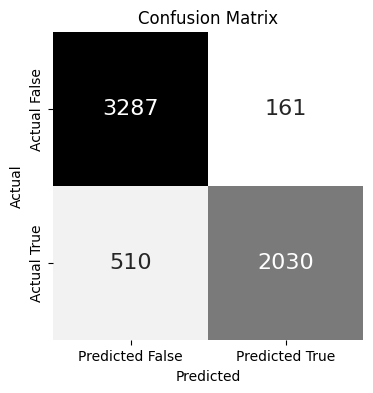


Some first degree errors (predicted true, actual false)), Total: 161


,Text
158,We should all have a fire safety plan. RT @Matt_Kroschel: MOCK WILDFIRE near #Vail as agencies prepare for the worst. http://t.co/SWwyLRk0fv
109,@BenignoVito @LibertyBell1000 HILLARYMASS MURDERER.
131,Nike Golf Storm Fit Golf Jacket Black Medium http://t.co/jvAI5Vkmsy: #SportingGoods http://t.co/Nr8JjmpmoS
55,For those displaced by disasters label and legal status remain out of reach https://t.co/kJMgTEEklp
94,Bayelsa poll: Tension in Bayelsa as Patience Jonathan plans to hijack APC PDP: Plans by former First Lady and... http://t.co/3eJL9lZlCH
29,Warne Ponting shocked by Australian collapse - Yahoo Cricket India https://t.co/hsgkTeZUCN
101,Stream HYPE HURRICANE
51,@Bonn1eGreer The Angel of History propelled into the future by the winds of progress leaves in its wake piles of death and destruction. WB
100,Entertain this thought for a moment:\n\ndiarrhea hurricane
144,OMEGA MEN Writer Explores Terrorism Religion In an 'Epic KYLE RAYNER Story' http://t.co/Hr88CWxPGz #Newsarama



Some second degree errors (predicted false, actual true)), Total: 510


,Text
86,@marcoarment Middle of winter in Sydney we have had snow bush fires and 78 degree days in the last week. Keeps you on your toes for sure.
350,@tinybaby @adultblackmale @mattytalks meltdown mwednesday
199,Could Billboard's Hot 100 chart be displaced by these social-media-driven music charts? http://t.co/WVlaH8jRXe
210,Wall of noise is one thing - but a wall of dust? Moving at 60MPH? http://t.co/9NwAJLi9cr How to not get blown away! http://t.co/j4NI4N0yFZ
87,@DoriCreates @alhanda seems gov moonbeam between tokes blames bush for all the fires.
138,SO THIRSTY YALL IN DANGER OF DEHYDRATION
31,Trial Date Set for Man Charged with Arson Burglary http://t.co/WftCrLz32P
40,STAR WARS POWER OF THE JEDI COLLECTION 1 BATTLE DROID HASBRO - Full read by eBay http://t.co/xFguklrlTf http://t.co/FeGu8hWMc4
192,@argentings WE COULD HAVE HAD IT AAAAAAALLLL IÛªm not even on that season and IÛªm devastated
476,@MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.


In [5]:
TFIDF_HGBC.validate(X_train, y_train)

Beim Auswerten des Modells auf den Trainingsdaten erreichen wir recht hohe Metriken. Das Modell macht aber sehr viele Fehler zweiten Grades.<br>
Wenn man aber die falsch klassifizierten Sätze sieht, sehen wir ein komisches Muster:<br>
Einige Sätze, welche als Katastrophe gelabeled werden, sehen nicht gerade nach Katastrophen aus oder können nur nach Einsicht eines Links so <br>klassifiziert werden. <br><br>
Zum Beispiel:<br> 
"@freeMurphy Your hot take on Canada's hitchhiking garbage-bot (destroyed in Philly) was sorely needed."<br>
"ok peace I hope I fall off a cliff along with my dignity"<br>
"This is the natural and unavoidable consequence of socialism everywhere it has been tried.http://t.co/BbDpnj8XSx A"<br>
"STAR WARS POWER OF THE JEDI COLLECTION 1 BATTLE DROID HASBRO - Full read by eBay http://t.co/xFguklrlTf http://t.co/FeGu8hWMc4"<br><br>
Bei den Fehlern ersten Grades kann man schon besser nachvollziehen, wieso das Modell diese falsch klassifiziert hat. <br>
Wörter wie "hostage", "suicide bomb", "storm", "wars", etc. werden genutzt, um einen Satz dramatischer wirken zu lassen. <br>
Das Modell hat Schwierigkeiten, diese Zusammenhänge im Kontext korrekt zu erkennen.

### Validierung auf Validierungsdaten

Metrics
Accuracy: 0.7889111556446226
F1 Macro: 0.7773587960435405

Confusion Matrix


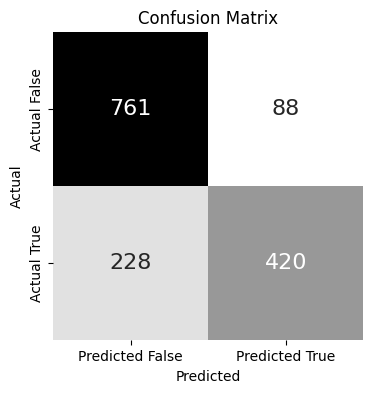


Some first degree errors (predicted true, actual false)), Total: 88


,Text
3,@marksmaponyane Hey!Sundowns were annihilated in their previous meeting with Celtic.Indeed its an improvement.
66,Captain Abbott must go down with LNP boat #refugees #christianvalues https://t.co/Kp5dpOaF58
86,GOP debate drinking game. For anyone looking for a bit of fun while watching this train wreck. http://t.co/W3Rga0nkOm http://t.co/0TZsQe8ESD
84,Camping in a war zone with roving raccoons toughens city slicker http://t.co/oJuS08yZrq
69,China's Stock Market Crash: Are There Gems In The Rubble?: ChinaÛªs stock market crash this summer h... http://t.co/pE2R3lN16o by .Forbes
79,I feel like that episode of Victorious when they all got trapped in an RV and almost died of heat stroke #MTVHottest One Direction
36,The Five Fatal Flaws in the Iran Deal https://t.co/ztfEAd8GId via @YouTube
76,FERNO would appreciate if everyone in EMS could dust off their engineering degree & inspect all stretcher components. http://t.co/GTEd6LDwho
64,- Pandemonium In Aba As Woman Delivers Baby Without Face http://t.co/36GccAPaak http://t.co/nqjZS6wkuN
43,@kristenKOIN6 Yay good cooler weather for PDX..ABQ NM is feeling the heat wave now bcuz my rain dances aren't working :-)



Some second degree errors (predicted false, actual true)), Total: 228


,Text
75,So you have a new weapon that can cause un-imaginable destruction.
99,Tube strike live: Latest travel updates as London is engulfed in chaos: Û_ cross-London travel will be accepte... http://t.co/vg8HRbebdA
96,Hello Calgary!! Important news!! Please be advised!!! http://t.co/ARKTJ9Qn4S
175,The real question is why is the tornado siren going off in Dyersburg?
34,Learning from the Legacy of a Catastrophic Eruption - The New Yorker http://t.co/vMWTOUyOHm
64,News Alerts - Glimpses: Hyderabad deluged by heavy rainfall
135,@pattonoswalt @FoxNews Wait I thought Fecal Hurricane was on SciFi? Maybe that was turdnado. I've been forgeting up a shit storm lately.
158,Oops: Bounty hunters try to raid Phoenix police chief's home: A group of armed bounty hunters surrounded the h... http://t.co/dGELJ8rYt9
48,AKILAH WORLD NEWS Cop pulls man from car to avoid this ... http://t.co/Vn2Fnmy7li
116,As firefighters make gains on #RockyFire Jerry Brown is heading to the area to meet with first responders tomorrow morning


In [6]:
TFIDF_HGBC.validate(X_val, y_val)

Beim Auswerten des Modells auf den Validierungsdaten sehen wir, dass die Scores deutlich zum Trainingsdatensatz gesunken sind, <br>jedoch noch gute Ergebnisse zeigen.<br>

Hier ist das Ausmass der Fehler zweiten Grades verglichen zu den Fehlern ersten Grades kleiner als bei der Validierung mit den Trainingsdaten.<br>
Viele Fehler zweiten Grades sind hier sehr warhscheinlich Antworten zu Threads, welche Katastrophenrelevant sind. <br>
Dies macht diese Klassifikation unglaublich schwierig, da der Kontext dafür einfach fehlt.

Zum Beispiel:<br> 
"@AsimTanvir @NemesisK_PES @KevR_7 Snow? Thunder and lightning?"<br>
"I agree with certain cultural appropriation things but honestly if u looked at my house it screams appropriation bc Buddhas and stuff-"<br>
"@DarrellIssa Does that 'great Iran deal' cover bioterrorism? You got cut off terrible of them. Keep up the good work."<br>

Bei den Fehlern ersten Grades ziehe ich die gleichen Erkenntnisse wie bei der Validierung mit den Testdaten.<br>
Es sieht so aus als würden einige Triggerwords wie z.B. "**Crash**" (von Crash Course) das Modell stark beinflussen.<br>
Das Modell zeigt Schwierigkeiten, diese Zusammenhänge im Kontext korrekt zu erkennen, <br>
beziehungsweise einen Bezug auf die anderen Wörter zu erstellen.<br>

Zum Beispiel:<br>
"China's Stock Market Crash: Are There Gems In The Rubble?"<br>

Hier wird von einem Stock Market Crash gesprochen, welcher nicht unbedingt eine Katastrophe (ausser für die Börse) ist.<br>

## Erkenntnisse

Hier werde ich stärker auf die Funktionsweise des Modells eingehen und die Erkenntnisse aus der Auswertung diskutieren.

In [7]:
# Feature Importance
feature_names, feature_importance = TFIDF_HGBC.get_feature_importance(X_train, y_train, metric="f1_macro")
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient="index")
feature_importance_df.columns = feature_names
feature_importance_df.T.sort_values(by="importances_mean", ascending=False).iloc[:, :2].head(20)

,importances_mean,importances_std
you,0.011036,0.001135
in,0.010264,0.000696
i,0.007675,0.001131
fire,0.007106,0.000907
http,0.00698,0.001089
evacu,0.006885,0.00087
murder,0.006516,0.000767
storm,0.005723,0.000338
kill,0.005719,0.000717
earthquak,0.005329,0.0007


Wenn man mittels Permutation Importance die wichtigsten Features extrahiert, dann macht die Feature Importance der ersten 3 Wörter wenig Sinn.<br> 
Jedoch erkennt man, dass das Modell stark auf die Präsenz von (entstammten und lemmatisierten) Wörtern schaut, welche für eine Katastrophe relevant sind.<br><br>
Da das Modell auch auf den TFIDF Wert schaut, müssen wir diesen auch berücksichtigen. <br>
Dafür multiplizieren wir die Feature Importance mit dem IDF Wert, um eine "Direkte Feature Relevanz" zu erhalten.

In [8]:
# Summed IDF
idf = TFIDF_HGBC.vectorizer.idf_
idf = pd.DataFrame(idf, index=feature_names, columns=["idf"])

# Direct Relevance
feature_importance_df = feature_importance_df.T
feature_importance_df["idf"] = idf
feature_importance_df["direct_relevance"] = feature_importance_df["importances_mean"] * feature_importance_df["idf"]
feature_importance_df["direct_relevance"].sort_values(ascending=False).head(20)

you          0.038026
murder       0.035603
evacu        0.035201
earthquak    0.032731
spill        0.030081
hiroshima    0.029304
storm        0.029144
fire         0.029024
kill         0.027283
wildfir      0.025553
disast       0.025234
in           0.025074
accid        0.024397
train        0.023667
flood        0.023184
bomb         0.022003
build        0.021273
i            0.021112
debri        0.018325
typhoon      0.018223
Name: direct_relevance, dtype: object

Hier erkennen wir unter Miteinberechnung der IDF Werte viel besser, welche Wörter am stärksten zur Klassifikationsentscheidung beitragen.<br><br>
Unter Betrachtung der Liste können wir klar erkennen, dass wenn Katastrophenrelevante Wörter im Satz vorkommen, <br>
der Satz als Katastrophe klassifiziert wird. Jedoch werden auch Wörter wie "you", "in" und "i" stark gewichtet. <br>
Dies ist sehr interessant, da diese Wörter nicht direkt Katastrophenrelevant sind und auf einen zu kleinen Datensatz hinweisen könnten.

## Vergleich zu SVM
Wir tauschen unser Klassifikationsmodell (TFIDF) gegen ein SVM Modell aus.

In [9]:
# Define Pipeline
TFIDF_SVM = Pipeline(
    vectorizer=TfidfVectorizer(
        max_features=1000,
        preprocessor=lambda tweet: preprocess(
            tweet,
            html_escape=True,
            tokenizer=nltk.word_tokenize,
            lemmatize=True,
            stem=True,
        ),
        tokenizer=nltk.word_tokenize,
        token_pattern=None,
    ),
    classifier=SVC(),
    reducer=None,  # None, PCA, NMF, etc.
)

# Fit Pipeline
TFIDF_SVM.fit(X_train, y_train)

Pipeline(vectorizer=TfidfVectorizer(max_features=1000,
                preprocessor=<function <lambda> at 0x2850dad40>,
                token_pattern=None,
                tokenizer=<function word_tokenize at 0x12299f600>), classifier=SVC(), reducer=None)

Metrics
Accuracy: 0.8069472277889111
F1 Macro: 0.7943866025952078

Confusion Matrix


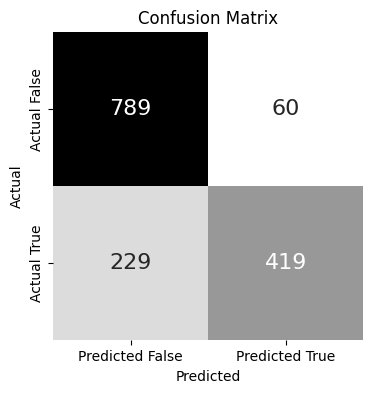


Some first degree errors (predicted true, actual false)), Total: 60


,Text
24,6 Things Getting Caught in a Dust Storm & the Challenging Real Estate Market Have in Common (+ video): http://t.co/jf5Ft5cq9j
53,The sky's clear the storm has passed but it's still raining in my head
6,Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
31,Kosciusko police investigating pedestrian fatality hit by a train Thursday http://t.co/m5djLLxoZP
26,Pls can alllll the nittys evacuate stockwell
25,Emergency Dispatchers in Boone County in the hot seat http://t.co/5fHkxtrhYU
3,RT: Our_Mother_Mary: Short Reading\n\nApocalypse 21:1023 \n\nIn the spirit the angel took me to the top of an enormous high mountain and... Û_
41,@nalathekoala As a health care professional that deals all gun violence sequalae I consider suicides injuries accidents and homicides
55,Billionaires have a plan to free half a billion dollars trapped in Venezuela for two years @BlakeSchmidt reports.\n\nhttp://t.co/gbqTc7Sp9C
21,Teen Disaster Preparedness Event in Van Nuys August 11 @ 5:30pm http://t.co/fXUX987vZx via @VanNuysCouncil



Some second degree errors (predicted false, actual true)), Total: 229


,Text
224,TWIA board approves 5 percent rate hike: The Texas Windstorm Insurance Association (TWIA) Board of Directors v... http://t.co/TWPl0NL8cx
93,Denali wolf population declined from 143 in 2007 2 just 48 in 2015. Reinstate emergency buffer zone #ProtectDenaliWolves @Alaska @adndotcom
43,Heard #SKH on the radio for the first time. Almost crashed the car. @5SOS @Ashton5SOS @Luke5SOS @Michael5SOS @Calum5SOS
130,@pattonoswalt @FoxNews Wait I thought Fecal Hurricane was on SciFi? Maybe that was turdnado. I've been forgeting up a shit storm lately.
92,I'm loving this classic barn shot! We may or may not have got electrocuted got stung a few times and stepped in... http://t.co/X6aSGRjsWC
111,I wanna set some shit on fire.
185,Aquarium Ornament Wreck Sailing Boat Sunk Ship Destroyer Fish Tank Cave Decor - Full read Û_ http://t.co/nosA8JJjiN http://t.co/WUKvdavUJu
151,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos).... http://t.co/lYXNjlxL8s http://t.co/CXYFqN3ue4
211,the war on drugs has turned the U.S. into a WAR zone.
155,-=-0!!!!. Photo: LASTMA officials challenge police for driving against traffic in Lagos http://t.co/8VzsfTR1bG


In [10]:
TFIDF_SVM.validate(X_val, y_val)

Wir erkennen, dass für diesen Use Case ein SVM Modell verglichen zum HGBC Modell ähnliche oder sogar bessere Ergebnisse liefert.<br>
Die Klassifikationsfehler ersten und zweiten Grades ähneln sich stark zum HGBC Modell.<br>

Um die Vorhersagen qualitativ zu evaluieren, speichern wir die Vorhersagen und die dazugehörigen Tweets in einer CSV Datei.

In [ ]:
val_predictions = []
for tweet, label, prediction in zip(X_val, y_val, TFIDF_HGBC.predict(X_val)):
    val_predictions.append({
        "tweet": tweet,
        "label": label,
        "prediction": prediction,
    })

pd.DataFrame(val_predictions).to_csv("data/val_predictions_tf_idf_svm.csv", index=False)

## Fazit

Als Ausgangspunkt verwenden wir ein äusserst leistungsfähiges Modell, das dank der Anwendung von TFIDF-Codierung und der beeindruckenden Leistung des HGBC-Verfahrens ohne erheblichen Rechenaufwand ausgezeichnete Ergebnisse erzielt. Die gleichen Ergebnisse konnten wir auch beim SVM erzielen.<br><br>
Dies unterstreicht die Bedeutung, auch einfachere Modelle in Betracht zu ziehen, da sie häufig ähnlich gute Ergebnisse erzielen können wie umfangreiche, zeitaufwändige und komplexe Modelle.<br><br>
Dennoch ist anzumerken, dass unser einfaches Modell nicht in der Lage ist, die gesamte Vielfalt der in den Datensätzen enthaltenen Sprache abzubilden. Dies liegt daran, dass unser Modell ausschliesslich auf einzelne Wörter fokussiert und Schwierigkeiten bei der Erkennung von Beziehungen zwischen Wörtern und sprachlichen Konzepten wie Ironie aufweist.


## Kaggle Submission

Hier lassen wir noch die Testdaten durch das Modell laufen und speichern die Ergebnisse in einer CSV Datei.<br>
Diese kann bei der Kaggle Competition hochgeladen werden.

In [11]:
kaggle_test = pd.read_csv("data/processed/test.csv", index_col="id", encoding="UTF-8")
X_test = kaggle_test.text.values

submisson = TFIDF_HGBC.predict(X_test)
submisson = pd.DataFrame(submisson, index=kaggle_test.index, columns=["target"])
submisson.to_csv("data/submissions/TFIDF_HGBC.csv", index=True, index_label="id")

submisson = TFIDF_SVM.predict(X_test)
submisson = pd.DataFrame(submisson, index=kaggle_test.index, columns=["target"])
submisson.to_csv("data/submissions/TFIDF_SVM.csv", index=True, index_label="id")